In [1]:
# Set up imports and libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.pipeline import Pipeline
import string
import pandas as pd
from nltk.corpus import stopwords


import nltk
#nltk.download('punkt')

In [2]:
#import the review data set
import numpy as np
import pandas as pd
yelp_reviews = []
r_dtypes = {"stars": np.float16, 
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32,
           }
with open("yelp_academic_dataset_review.json", "r", encoding='utf8') as f:
    reader = pd.read_json(f, orient="records", lines=True, 
                          dtype=r_dtypes, chunksize=1000)
        
    for chunk in reader:
        reduced_chunk = chunk.drop(columns=['review_id', 'user_id'])\
                             .query("`date` >= '2022-01-01'")
        yelp_reviews.append(reduced_chunk)
    
yelp_reviews = pd.concat(yelp_reviews, ignore_index=True)
#yelp_reviews.describe #80k rows for 12/1/21; 31665  for 2022-01-01

In [3]:
# import business dataset
import pandas as pd
yelp_busn = []
r_dtypes = {"stars": np.float16, 
            "latitude": np.int32, 
            "longitude": np.int32,
           }
with open("yelp_academic_dataset_business.json", "r", encoding='utf8') as f:
    reader = pd.read_json(f, orient="records", lines=True, 
                          dtype=r_dtypes, chunksize=1000)
        
    for chunk in reader:
        reduced_chunk = chunk.drop(columns=['is_open', 'longitude','latitude','hours'])\
                             .query("`city` >= 'philadelphia'")
        yelp_busn.append(reduced_chunk)
    
yelp_busn = pd.concat(yelp_busn, ignore_index=True)
#yelp_busn.describe

In [99]:
yelp_busn
#MexicanBusinesses = yelp_busn[yelp_busn['categories'].isIn(['Mexican'])]
FL_busn = yelp_busn[yelp_busn['state'].isin(['FL'])]
pd.dataframe(FL_busn['business_id']                      )

AttributeError: module 'pandas' has no attribute 'dataframe'

In [4]:
# append text length of review
yelp_reviews.describe
yelp_reviews['text length'] = yelp_reviews['text'].apply(len)
yelp_reviews.head()

,business_id,stars,useful,funny,cool,text,date,text length
0,drTZrkbpSoJgwKETlFbc3w,1.0,0,0,0,I bought a Fender 1966 Telecaster that the sal...,2022-01-01 15:47:07,641
1,jyxHti29yWdYR00Itt1A2w,5.0,0,0,0,This is our go to for take out when I visit my...,2022-01-02 03:49:01,208
2,Jo4ei-c-5H53IxZxAVf1jQ,5.0,0,0,0,Danielle did a great job! She listened and cu...,2022-01-03 03:17:03,278
3,YT5CjacTllBtvMaMJS3IbA,1.0,0,0,0,We saw a lot of roaches in the bathroom when w...,2022-01-05 15:55:59,514
4,9MHe5jAym2d8VhT_NbCRyw,2.0,0,0,0,We Ordered pork fried rice and beef chow mei ...,2022-01-06 03:59:21,148


In [55]:
# Data Pre Processing
# 1. Remove Stop Words
# 2. Stem
# 3. Tokenize
# 4. Counts
# 5. Replace smileies

#does not filter to restaurants - need business dataset
#createa dataset without 3 stars since those are neutral
yelp_data = yelp_reviews[(yelp_reviews['stars'] > 3) | (yelp_reviews['stars'] < 3)]
#yelp_reviews['label'] = 0

X = pd.DataFrame(yelp_data['text'])
y = pd.DataFrame(yelp_data['stars'])

Xhead = X.head()
Xhead
Yhead = y.head()
Yhead

,stars
0,1.0
1,5.0
2,5.0
3,1.0
4,2.0


In [56]:
#1 Remove stop words - Done
def process_text(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

X
Xhead['text'] = Xhead['text'].apply(process_text)
Xhead

C:\Users\mcdc9\AppData\Local\Temp/ipykernel_17404/3065777248.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xhead['text'] = Xhead['text'].apply(process_text)


,text
0,"[bought, Fender, 1966, Telecaster, salesperson..."
1,"[go, take, visit, son, restaurant, desert, hom..."
2,"[Danielle, great, job, listened, cut, hair, wa..."
3,"[saw, lot, roaches, bathroom, woke, us, also, ..."
4,"[Ordered, pork, fried, rice, beef, chow, mei, ..."


In [67]:
#1 Remove stop words - for X instead of test set (takes long time)
def process_text(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

X
X['text'] = X['text'].apply(process_text)

KeyboardInterrupt: 

In [57]:
# 2 Stem - Done
from nltk.stem.snowball import SnowballStemmer
snowBallStemmer = SnowballStemmer("english")
Xhead['stemmed'] = Xhead['text'].apply(lambda x: [snowBallStemmer.stem(y) for y in x]) # Stem every word.
Xhead = Xhead.drop(columns=['text']) # Get rid of the unstemmed column.
Xhead # Print dataframe.

C:\Users\mcdc9\AppData\Local\Temp/ipykernel_17404/4210125179.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xhead['stemmed'] = Xhead['text'].apply(lambda x: [snowBallStemmer.stem(y) for y in x]) # Stem every word.


,stemmed
0,"[bought, fender, 1966, telecast, salesperson, ..."
1,"[go, take, visit, son, restaur, desert, home, ..."
2,"[daniell, great, job, listen, cut, hair, way, ..."
3,"[saw, lot, roach, bathroom, woke, us, also, se..."
4,"[order, pork, fri, rice, beef, chow, mei, fun,..."


In [ ]:
# 2 Stem - - for X instead of test set (takes long time)
from nltk.stem.snowball import SnowballStemmer
snowBallStemmer = SnowballStemmer("english")
X['stemmed'] = X['text'].apply(lambda x: [snowBallStemmer.stem(y) for y in x]) # Stem every word.
X = X.drop(columns=['text']) # Get rid of the unstemmed column.

In [59]:
# 3. Tokenize data to turn words into integers for modeling
cv = CountVectorizer() #stop_words=my_stop_words, ngram_range=(2,2
Xhead['stemmed']=[" ".join(review) for review in Xhead['stemmed'].values] #convert from list to text
Xhead_cv = cv.fit_transform(Xhead['stemmed'])

In [ ]:
# 3. Tokenize data to turn words into integers for modeling
cv = CountVectorizer() #stop_words=my_stop_words, ngram_range=(2,2
Xhead['stemmed']=[" ".join(review) for review in Xhead['stemmed'].values] #convert from list to text
Xhead_cv = cv.fit_transform(Xhead['stemmed'])

In [60]:
Xhead_cv

<5x140 sparse matrix of type '<class 'numpy.int64'>'
	with 150 stored elements in Compressed Sparse Row format>

<BarContainer object of 10 artists>

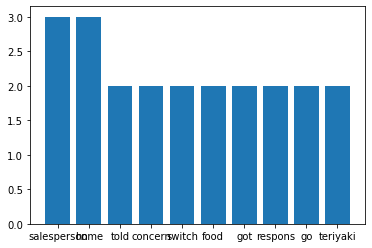

In [61]:
bigram_df = pd.DataFrame(Xhead_cv.toarray(), columns=cv.get_feature_names_out())
bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['bigram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(by='frequency', ascending=False).head(10)
plt.bar(bigram_frequency['bigram'],bigram_frequency['frequency'])

In [66]:
Xhead_cv
print('Shape of Sparse Matrix: ', Xhead_cv.shape)
print('Amount of Non-Zero occurrences: ', Xhead_cv.nnz)
# Percentage of non-zero values
density = (100.0 * Xhead_cv.nnz / (Xhead_cv.shape[0] * Xhead_cv.shape[1]))
print("Density: {}".format((density)))

#graphics
#wordcloud failed
#reviews over time
#dist of star ratings
#length fo text for ratings
#avg monthly rtating
#Xhead('text'.most_common(20),columns=['Word', 'Frequency'])

Shape of Sparse Matrix:  (5, 140)
Amount of Non-Zero occurrences:  150
Density: 21.428571428571427


In [63]:
# set up nb model and run predictions
X_train, X_test, y_train, y_test = train_test_split(Xhead_cv, Yhead,test_size=0.3,random_state=101)
nb = MultinomialNB()
nb.fit(X_train,y_train)

predictions = nb.predict(X_test)
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[0 0 1]
 [0 0 1]
 [0 0 0]]


              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       1.0
         2.0       0.00      0.00      0.00       1.0
         5.0       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



C:\Users\mcdc9\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mcdc9\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mcdc9\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mcdc9\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Preci

In [ ]:
#nltk.download('vader_lexicon')
# Load SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Instantiate new SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
# Generate sentiment scores
sentiment_scores = Xhead['stemmed'].apply(sid.polarity_scores)
sentiment = sentiment_scores.apply(lambda x: x['compound']) #get compound score
sentiment
#could graph over time